**Steps**
- bring in target from binary_categories table for data encryption practices ONLY FOR sites in OPP-115
- bring in features from segment table ONLY FOR sites in OPP-115
- check for length!
- set up text processing functions
- set up BOW >> TFIDF >> Naive Bayes pipeline
- train-test-split data
- fit, predict, check classification
- wash, rinse, repeat
- pickle out trained model

In [1]:
#Basic imports
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import *
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#Notifications
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [3]:
#Database imports and credentials
import psycopg2

In [4]:
#Establish database connection
dbname = 'beforeiagree_db'
username = 'peterostendorp'

#Create engine
con = psycopg2.connect(database = dbname, user = username)

## Segment-level model

In [5]:
sql = """
SELECT "Policy UID", segment_id, data_security FROM binary_segment_categories
WHERE binary_segment_categories."Policy UID" IN
(SELECT "Policy UID" FROM sites
WHERE sites."In 115 Set?" IS TRUE);
"""

targets_segments = pd.read_sql_query(sql,con)

In [6]:
targets_segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6469 entries, 0 to 6468
Data columns (total 3 columns):
Policy UID       6469 non-null int64
segment_id       6469 non-null int64
data_security    6469 non-null int64
dtypes: int64(3)
memory usage: 151.7 KB


In [7]:
targets_segments['data_security'].value_counts()

0    6173
1     296
Name: data_security, dtype: int64

In [8]:
targets_segments['data_security'].value_counts()[1]/targets_segments['data_security'].count()

0.045756685731952386

Note: only about 4.6% of segments in these documents pertain to this topic.

In [9]:
targets_segments.groupby('Policy UID').sum()['data_security'].value_counts()

1     44
2     25
0     17
6      7
3      6
4      4
18     2
9      2
8      2
5      2
14     1
13     1
12     1
7      1
Name: data_security, dtype: int64

But most **documents** have at least 1 mention, if not several.

In [6]:
#Get segments associated with policies in the OPP-115 corpus
sql = """
SELECT * FROM segments_processed
WHERE "Policy UID" IN 
(SELECT "Policy UID" FROM sites
WHERE "In 115 Set?" = TRUE)
"""

segments = pd.read_sql_query(sql,con)

In [7]:
print(segments.shape)
segments.head()

(6469, 4)


,index,Policy UID,segment_id,segments
0,0,20,0,privaci polici effect januari 1 2015 atlant mo...
1,1,20,1,privaci polici appli site maintain compani org...
2,2,20,2,visit site accept practic describ privaci poli...
3,3,20,3,inform collect collect two basic type inform c...
4,4,20,4,person identifi inform general matter brows si...


### Feature engineering for segment pre-processing

In [8]:
#Initial text-processing function for segments... not much needed here.
#Set up our initial text cleaning function
def text_process_policy(doc):
    """
    1. remove HTML tags
    2. remove punctuation
    3. remove stopwords
    4. stemming
    5. remove '|||' inserted into corpus documents only
    
    Returns a string of the processed doc.
    """
    sn = SnowballStemmer(language='english')
    
    lst = [word for word in doc.split() if re.search(r'\<.*\>',word) is None]
    lst = ' '.join(lst)
    lst = [char for char in lst if char not in string.punctuation]
    lst = ''.join(lst)    
    lst = [word.lower() for word in lst.split() if word.lower() not in stopwords.words('english')]
    lst = [sn.stem(word) for word in lst]
    lst = [word for word in lst if word.replace('|||','')]
    return ' '.join(lst)

In [8]:
#Process the segments here
segments['segments'] = segments['segments'].apply(text_process_policy)

In [192]:
#Print a few of them at random
for i in range(0,10):
    print(segments['segments'].iloc[np.random.randint(0,6000)])

also use third parti various servic relat onlin servic includ custom support technic support contest data collect email fulfil enter contest sign receiv newslett may share person inform necessari third parti provid servic behalf third parti permit use inform market purpos
7 notif chang whenev kinja chang privaci polici post chang privaci polici page place deem appropri user alway awar inform collect use circumst disclos prior version privaci polici found version found weve made recent chang respons review becom familiar chang agreement
coregistr offer immedi follow registr choos access offer good servic avail select thirdparti compani coregistr vendor may make certain contact demograph inform provid eg name age andor email address avail vendor consent
advertis cooki third parti advertis partner may distribut cooki user advertis provid us kinja access control cooki receiv advertis advertis servic use deliv advertis may engag onlin behavior advertis defin digit advertis allianc ftc
data 

In [9]:
from nltk.probability import FreqDist

In [10]:
data_security_segments = segments.merge(targets_segments,on=['Policy UID','segment_id']).drop_duplicates()
words = ' '.join(list(data_security_segments[data_security_segments['data_security']==1]['segments'])).split()

In [11]:
f = FreqDist(words)
df2 = pd.DataFrame(f.most_common(100),columns=['Word','Frequency']).set_index('Word')

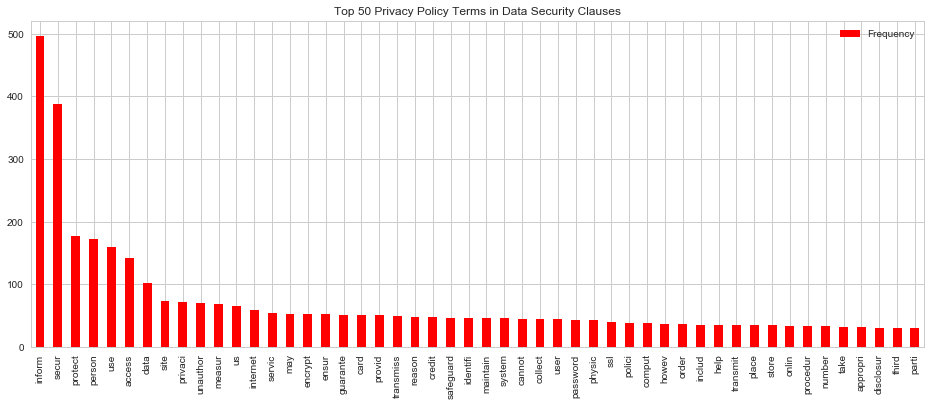

In [12]:
#Word frequency stuff
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
n_words = 50
sns.set_style('whitegrid')
df2.iloc[:n_words].plot.bar(figsize=(16,6),color='red')
plt.title('Top %s Privacy Policy Terms in Data Security Clauses' % n_words)
plt.xlabel('')

In [12]:
#Split data using 30%/70% split, random seed is my birthday
segments_train, segments_test, targets_train, targets_test = train_test_split(data_security_segments['segments'], 
    data_security_segments['data_security'], test_size=0.3, random_state=84)

### Naive Bayes approach

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score

In [14]:
#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops a Naive Bayes classifier.
data_encryption_NB_segment = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [56]:
#Build out ROC curve for variety of n_classifiers
data_encryption_NB_segment.fit(segments_train, targets_train)
targets_prob = data_encryption_NB_segment.predict_proba(segments_test)
preds = data_encryption_NB_segment.predict(segments_test)
fpr, tpr, thresholds = roc_curve(targets_test, targets_prob[:,1])
prec, rec, thresholds2 = precision_recall_curve(targets_test, targets_prob[:,1],1)
roc_auc = auc(fpr,tpr)
#rec_auc = auc(prec,rec)

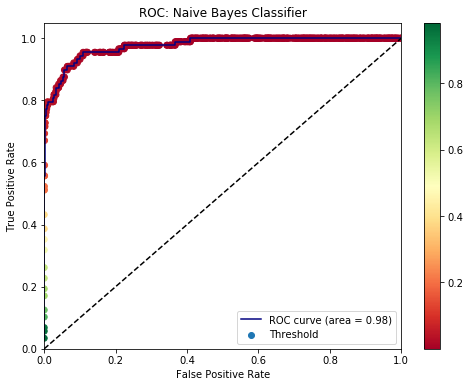

In [16]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % roc_auc)
plt.scatter(fpr, tpr, c=thresholds, cmap='RdYlGn', label='Threshold')
plt.colorbar()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Naive Bayes Classifier')
plt.legend(loc="lower right")

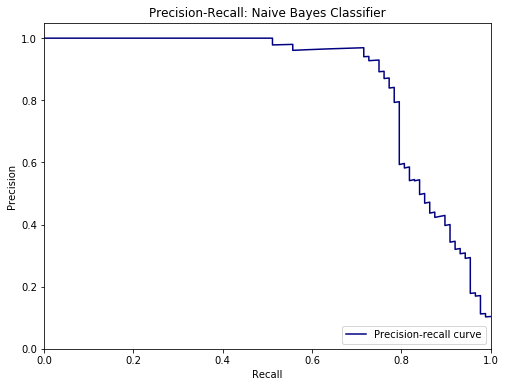

In [60]:
#Plotting out the Precision-recall curve
plt.figure(figsize=(8,6))
plt.plot(rec, prec, color='navy', label='Precision-recall curve')
#plt.scatter(rec, prec, c=thresholds2, cmap='RdYlGn', label='Threshold')
#plt.colorbar()
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall: Naive Bayes Classifier')
plt.legend(loc="lower right")

## Current model threshold 0.05

In [45]:
#Pick the best threshold
best = 0.05
data_encryption_NB_final = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])
data_encryption_NB_final.fit(segments_train,targets_train)
#preds = data_encryption_NB_final.predict(segments_test)
preds = data_encryption_NB_final.predict_proba(segments_test)[:,1]
preds[preds >= best] = 1
preds[preds < best] = 0
#print(preds)

In [46]:
#Quick diagnostics
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[1836   17]
 [  19   69]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1853
          1       0.80      0.78      0.79        88

avg / total       0.98      0.98      0.98      1941



In [28]:
import pickle
with open('../pickles/data_encryption_NB_segment.pkl','wb') as file:
    pickle.dump(data_encryption_NB_final,file)

### Random Forest Classifier

**Observations**
- more estimators don't seem to help much
- feature pre-processing seems to be the bigger factor

In [185]:
from sklearn.ensemble import RandomForestClassifier

In [186]:
#New pipeline
data_encryption_RF_segment = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier(class_weight='balanced'))
])

In [59]:
#Do a k-fold cross validation and get AUC for ROC curve for each
cv = KFold(n_splits=5,random_state=84)
scoring='roc_auc'

results = cross_val_score(data_encryption_RF_segment,segments_train,targets_train,cv=cv,scoring=scoring)
print('AUC: min %0.3f, mean %0.3f, max %0.3f' % (results.min(), results.mean(), results.max()))

AUC: min 0.486, mean 0.517, max 0.544


In [187]:
#Build out ROC curve for variety of n_classifiers
n_estimators = [10,50,100]
fpr = {}
tpr = {}
roc_auc = {}

for n in n_estimators:
#     data_encryption_RF_segment = Pipeline([
#         ('bow',CountVectorizer()),
#         ('tfidf',TfidfTransformer()),
#         ('classifier',RandomForestClassifier(class_weight='balanced',n_estimators=n))
#     ])
    params = {'classifier__n_estimators': n}
    data_encryption_RF_segment.set_params(**params)
    data_encryption_RF_segment.fit(segments_train, targets_train)
    targets_prob = data_encryption_RF_segment.predict_proba(segments_test)
    #preds = data_encryption_RF_segment.predict(segments_test)
    fpr[n], tpr[n], __ = roc_curve(targets_test, targets_prob[:,1])
    roc_auc[n] = auc(fpr[n],tpr[n])

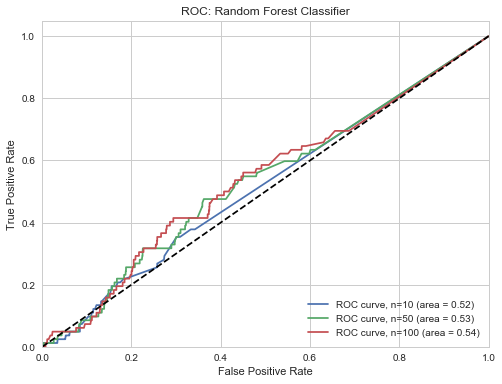

In [188]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for n in n_estimators:
    plt.plot(fpr[n], tpr[n], label='ROC curve, n=%s (area = %0.2f)' % (n,roc_auc[n]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Random Forest Classifier')
plt.legend(loc="lower right")

In [123]:
#Quick diagnostics
print(confusion_matrix(targets_test,preds_segments))
print(classification_report(targets_test,preds_segments))

[[1754  105]
 [  80    2]]
             precision    recall  f1-score   support

          0       0.96      0.94      0.95      1859
          1       0.02      0.02      0.02        82

avg / total       0.92      0.90      0.91      1941



## Policy-level model
### Multinomial Naive Bayes

In [193]:
#Select category targets
sql = """
SELECT "Policy UID",data_security FROM binary_policy_categories
WHERE "Policy UID" IN 
(SELECT "Policy UID" FROM sites
WHERE "In 115 Set?" = TRUE)
"""

targets_policies = pd.read_sql_query(sql,con)

In [194]:
targets_policies.head()

,Policy UID,data_security
0,20,1
1,21,1
2,26,1
3,32,1
4,33,1


In [195]:
#Select original policies as features
sql = """
SELECT "Policy UID", policy_text FROM sites
WHERE sites."In 115 Set?" = TRUE
"""

policies = pd.read_sql_query(sql,con)

In [196]:
policies.head()

,Policy UID,policy_text
0,20,<strong> Privacy Policy </strong> <br> <br> <s...
1,21,"IMDb Privacy Notice <br> <br>|||Last Updated, ..."
2,26,<strong> Privacy Policy </strong> <br> <br> La...
3,32,Vox Media Privacy Policy <br> <br>|||<strong> ...
4,33,Full Privacy Policy <br> <br> Last updated: 14...


In [197]:
#Split data using 30%/70% split, random seed is my birthday
policies_train, policies_test, targets_train, targets_test = train_test_split(policies['policy_text'], 
    targets_policies['data_security'], test_size=0.3, random_state=84)

In [198]:
policies_train = policies_train.map(text_process_policy)
policies_test = policies_test.map(text_process_policy)

In [199]:
#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops a Naive Bayes classifier.
data_encryption_NB_policy = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [202]:
#Now fit/train the model
data_encryption_NB_policy.fit(policies_train,targets_train)
targets_prob = data_encryption_NB_policy.predict_proba(policies_test)
preds = data_encryption_NB_policy.predict(policies_test)
fpr, tpr, thresh = roc_curve(targets_test, targets_prob[:,1])
roc_auc = auc(fpr,tpr)

In [203]:
thresh

array([ 0.97745218,  0.94137656,  0.93938354,  0.93771542,  0.9357203 ,
        0.89941673,  0.88990142,  0.81776601])

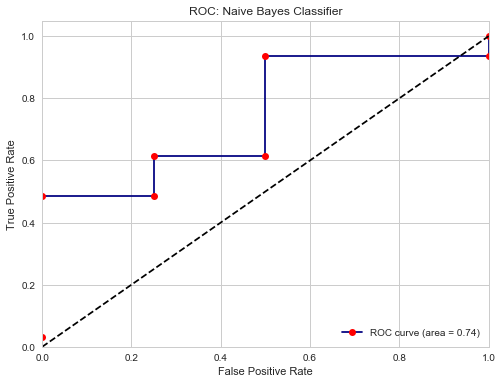

In [204]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % roc_auc,
        marker='o',markerfacecolor='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Naive Bayes Classifier')
plt.legend(loc="lower right")

Note: optimal performance appears to occur at about the 6th point.

In [210]:
#Set the final model and re-predict
opt = thresh[3] #The 6th point
data_encryption_NB_policy_final = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB(class_prior=[1-opt,opt]))
])
data_encryption_NB_policy_final.fit(policies_train,targets_train)
preds = data_encryption_NB_policy_final.predict(policies_test)

In [211]:
#Report
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[ 0  4]
 [ 0 31]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.89      1.00      0.94        31

avg / total       0.78      0.89      0.83        35



/Users/peterostendorp/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [213]:
#Pickle out the model
import pickle
with open('../pickles/data_encryption_NB_policy.pkl', 'wb') as file:
    pickle.dump(data_encryption_NB_policy_final,file)

### Adaptive boosting

In [138]:
from sklearn.ensemble import AdaBoostClassifier

**TO DO**
- consider different tokenizer
- bigrams?
- pass in legal dictionary

In [139]:
#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops an AdaBoost classifier with 100 weak learners.
data_encryption_ADA_policy = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',AdaBoostClassifier())
])

In [141]:
#Now fit/train the model
#Build out ROC curve for variety of n_classifiers
n_estimators = [10,50,100]
fpr = {}
tpr = {}
roc_auc = {}

for n in n_estimators:
    params = {'classifier__n_estimators': n}
    data_encryption_ADA_policy.set_params(**params)
    data_encryption_ADA_policy.fit(policies_train, targets_train)
    targets_prob = data_encryption_ADA_policy.predict_proba(policies_test)
    #preds = data_encryption_RF_segment.predict(segments_test)
    fpr[n], tpr[n], __ = roc_curve(targets_test, targets_prob[:,1])
    roc_auc[n] = auc(fpr[n],tpr[n])

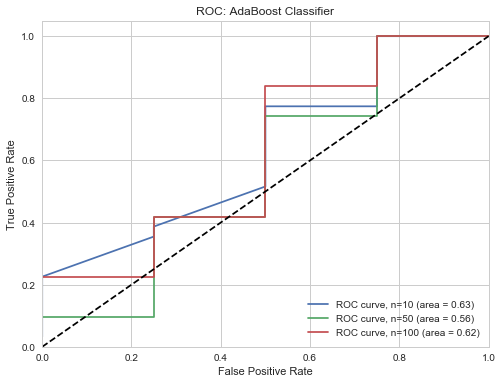

In [142]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for n in n_estimators:
    plt.plot(fpr[n], tpr[n], label='ROC curve, n=%s (area = %0.2f)' % (n,roc_auc[n]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: AdaBoost Classifier')
plt.legend(loc="lower right")

In [143]:
#Report
preds = data_encryption_ADA_policy.predict(policies_test)
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[ 2  2]
 [ 6 25]]
             precision    recall  f1-score   support

          0       0.25      0.50      0.33         4
          1       0.93      0.81      0.86        31

avg / total       0.85      0.77      0.80        35



In [86]:
import pickle

In [87]:
with open('../pickles/data_encryption_ADA_policy.pkl', 'wb') as file:
    pickle.dump(data_encryption_ADA_policy,file)

## Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [155]:
#Set up an sklearn pipeline that processes policies, transforms them into a BOW model, applies TFIDF metric,
#then develops an AdaBoost classifier with 100 weak learners.
data_encryption_RF_policy = Pipeline([
    ('bow',CountVectorizer(ngram_range=(2,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier(class_weight='balanced'))
])

In [158]:
#Now fit/train the model
#Build out ROC curve for variety of n_classifiers
n_estimators = [10,50,100,200,300]
fpr = {}
tpr = {}
roc_auc = {}

for n in n_estimators:
    params = {'classifier__n_estimators': n}
    data_encryption_RF_policy.set_params(**params)
    data_encryption_RF_policy.fit(policies_train, targets_train)
    targets_prob = data_encryption_RF_policy.predict_proba(policies_test)
    #preds = data_encryption_RF_segment.predict(segments_test)
    fpr[n], tpr[n], __ = roc_curve(targets_test, targets_prob[:,1])
    roc_auc[n] = auc(fpr[n],tpr[n])

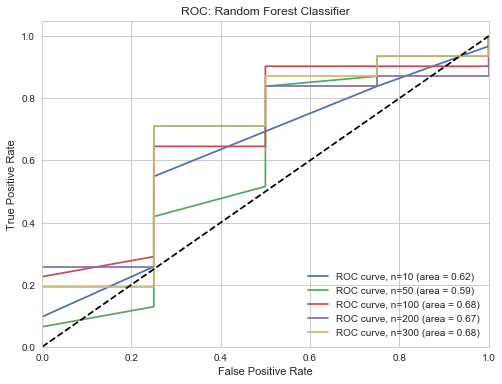

In [159]:
#Plotting out the ROC curve
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for n in n_estimators:
    plt.plot(fpr[n], tpr[n], label='ROC curve, n=%s (area = %0.2f)' % (n,roc_auc[n]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Random Forest Classifier')
plt.legend(loc="lower right")

In [160]:
#Predict
preds = data_encryption_RF_policy.predict(policies_test)

In [161]:
#Report
print(confusion_matrix(targets_test,preds))
print(classification_report(targets_test,preds))

[[ 0  4]
 [ 2 29]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.88      0.94      0.91        31

avg / total       0.78      0.83      0.80        35



In [94]:
# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../pickles/data_encryption_RF_policy.pkl', 'wb') as file:
    pickle.dump(data_encryption_RF_policy,file)